# Exercise 7) Learning and Planning

In this exercise, we will again investigate the inverted pendulum from the `gymnasium` environment. We want to check, which benefits the implementation of planning offers.

Please note that the parameter $n$ has a different meaning in the context of planning (number of planning steps per actual step) than in the context of n-step learning.

In [2]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time
import random
import numpy as np
import gymnasium as gym
gym.logger.set_level(40)
plt.style.use('seaborn')


We will reuse the discretization routine from the previous exercise:

In [3]:
d_T = 15
d_theta = 15
d_omega = 15


def discretize_state(states):
    limits = [1, 1, 8]
    nb_disc_intervals = [d_theta, d_theta, d_omega]

    # bring to value range [-1, 1]
    norm_states = [state / limit for state, limit in zip(states, limits)]
    interval_lengths = [2 / d for d in nb_disc_intervals]
    disc_state = [(norm_state + 1) // interval_length for norm_state,
                  interval_length in zip(norm_states, interval_lengths)]
    disc_state = [(state - 1) if state == d else state for state,
                  d in zip(disc_state, nb_disc_intervals)]  # ensure that disc_state < d

    return np.array(disc_state)


def continualize_action(disc_action):
    limit = 2
    interval_length = 2 / (d_T-1)
    norm_action = disc_action * interval_length
    cont_action = (norm_action - 1) * limit
    return np.array(cont_action).flatten()


## 1) Dyna-Q

Write a Dyna-Q algorithm to solve the inverted pendulum. Check the quality of the result for different number of episodes, number of steps per episode and number of planning steps per interaction.

Make sure that the total number of learning steps stays the same for different n, such that comparisons are fair:

$\text{episodes} \cdot \text{steps} \cdot (1+n) = \text{const.}$

Interesting metrics for a comparison could be e.g. the execution time (the tqdm loading bar shows execution time of loops, alternatively you can use the time.time() command to get the momentary system time in seconds) and training stability. 

![](DynaQ_Algo.png)

## Solution 1)

The solution code is given below.


In [4]:
def pendulumDynaQ(alpha, gamma, epsilon, n, nb_episodes, nb_steps):

    env = gym.make('Pendulum-v1')
    env = env.unwrapped

    action_values = np.zeros([d_theta, d_theta, d_omega, d_T])
    pi = np.zeros([d_theta, d_theta, d_omega])

    model = {} # dictionary

    cumulative_reward_history = [] # we can use this to figure out how well the learning worked
    pbar = tqdm(range(nb_episodes))

    for j in pbar:
        
        ### BEGIN SOLUTION

        rewards = [] # this time, this list is only for monitoring

        state, _ = env.reset() # initialize x_0
        state = tuple(discretize_state(state).astype(int))

        for k in range(nb_steps):

            # sample experiences for the model
            if np.random.uniform(0, 1) < epsilon:
                action = np.random.choice(d_T) # explorative action
            else:
                action = pi[state].astype(int) # exploitative action        

            cont_action = continualize_action(action)
            next_state, reward, terminated, _, _ = env.step(cont_action)
            next_state = tuple(discretize_state(next_state).astype(int))

            # learn from the momentary experience
            action_values[state][action] += alpha * (reward 
                                                          + gamma * np.max(action_values[next_state])
                                                          - action_values[state][action]
                                                         )
            pi[state] = np.argmax(action_values[state])
            model[state, action] = (next_state, reward) # update the model accoring to the latest experience
            state = next_state

            rewards.append(reward)     


            # learn from the model, IMPORTANT: USE DIFFERENT VARIABLES HERE
            for i in range(n):
                # sample a random key from the dict: this state action combination has surely been taken in the past
                x, u = random.sample(model.keys(), 1)[0]
                x_1, r = model[x, u]
                action_values[x][u] += alpha * (r 
                                                + gamma * np.max(action_values[x_1])
                                                - action_values[x][u]
                                               )
                pi[x] = np.argmax(action_values[x])

            if terminated:
                break
        
        pbar.set_description(f"Cumulative_reward {np.sum(rewards):6.0f}, Progress")

        cumulative_reward_history.append(np.sum(rewards))

    env.close()
    
    ### END SOLUTION
    
    return cumulative_reward_history, pi



Function to evaluate and render the measurement using the gym environment:

In [5]:
def experiment(pi, nb_steps=300, render=False):
# Runs the inverted pendulum experiment using policy pi for nb_steps steps

    if render:
        env = gym.make('Pendulum-v1', render_mode="human")
    else:
        env = gym.make('Pendulum-v1')
    env = env.unwrapped

    state, _ = env.reset() # initialize x_0
    disc_state = tuple(discretize_state(state).astype(int)) # only tuples of integers can be used as index 
    disc_action = pi[disc_state].astype(int)

    for k in range(nb_steps):

        cont_action = continualize_action(disc_action)
        if render:
            env.render() # comment out for faster execution
        state, reward, terminated, _, _  = env.step(cont_action)
        disc_state = tuple(discretize_state(state).astype(int))

        if terminated:
            break

        disc_action = pi[disc_state].astype(int) # exploitative action

    env.close()

Let's use nb_episodes = 5000, nb_steps = 500, n = 0 as a first try. This is effectively Q learning.

\begin{align}
5000 \cdot 500 \cdot (0+1) &= 2.5 \cdot 10^6
\end{align}

The resulting policy is satisfactory.



In [6]:
# train
print("Run without planning")
no_planning_history, no_planning_pi = pendulumDynaQ(alpha=0.1, gamma=0.9, epsilon=0.1, n=0, nb_episodes=5000, nb_steps=500)


Run without planning


  0%|          | 0/5000 [00:00<?, ?it/s]

In [7]:
# run and render the experiment
experiment(no_planning_pi, nb_steps=300, render=True)

Now let's try $n=9$ with the same nb_steps = 500:

\begin{align}
\text{nb_episodes} &= \frac{2.5 \cdot 10^6}{500 \cdot (9+1)} = 500
\end{align}

The resulting policy also looks good.



In [8]:
# train
print("Run with planning")
with_planning_history, with_planning_pi = pendulumDynaQ(alpha=0.1, gamma=0.9, epsilon=0.1, n=9, nb_episodes=500, nb_steps=500)


Run with planning


  0%|          | 0/500 [00:00<?, ?it/s]

In [9]:
# run and render the experiment
experiment(with_planning_pi, nb_steps=300, render=True)


Now lets compare the cumulative rewards:


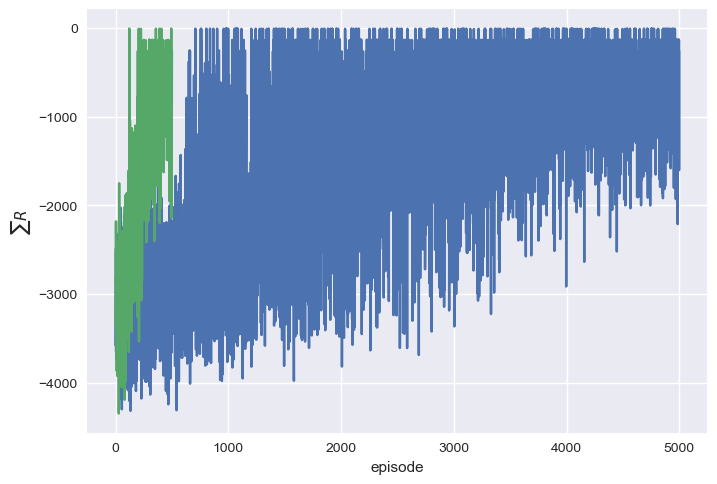

In [10]:
plt.plot(no_planning_history)
plt.plot(with_planning_history)
plt.xlabel("episode")
plt.ylabel(r"$\sum R$")
plt.show()


The cumulative reward over the episodes both seems to have high variance.

So why should we prefer the planning method?
### Planning leads to the agent interacting less often with the "real" environment, such that in the end fewer interaction time is needed.

## 2) Simulation-based planning

Although it can be useful for small state spaces, building a system model by storing large amounts of state transitions like in task (1) is rarely feasible in engineering. As engineers, we are capable of a more efficient way of system modeling that we can utilize here: differential equations.

Using a state-space model allows to efficiently integrate existing pre-knowledge into the Dyna-Q algorithm we already used. To do so, write a class `pendulum_model` that implements a model of the pendulum. This class should work similar to `gymnasium`: it should at least have a `step` and a `reset` method. In the step method, make use of forward Euler integration to simulate the system dynamics. In the reset method, allow to pass an optional initial state to the model, such that we can easily compare model and environment. If no initial state is passed to the `reset` function, a random initial state should be determined.

Integrate this model into a Dyna-Q algorithm.

Model of the pendulum in differential-equation form for change of the angular frequency $\omega$ and the angle $\theta$ depending on the torque $T_\mathrm{u}$:

\begin{align*}
\dot{\omega} &= -\frac{3 g}{2 l} \text{sin}(\theta +\pi) + \frac{1}{J} T_\mathrm{u}
\\
\dot{\theta} &= \omega
\end{align*}



Parameters (gravity constant $g$, mass $m$, length  $l$ and intertia $J$ of the pendulum):

\begin{align*}
g&=10 \, \frac{\text{m}}{\text{s}^2}
\\
m&=1 \, \text{kg}
\\
l&=1 \, \text{m}
\\
J&=\frac{1}{3} m l^2
\end{align*}

Forward Euler integration:

\begin{align*}
\dot{x}(k T_S) \approx \frac{x[k+1] - x[k]}{T_S}
\end{align*}

with sampling time $T_S = 0.05 \, \text{s}$

Reward function:

\begin{align*}
r_{k+1} = -(\theta^2[k] + 0.1 \, \text{s}^2 \cdot \omega^2[k] + 0.001 \frac{1}{(\text{N}\text{m})^2} \cdot T_\mathrm{u}^2[k])
\end{align*}

Limitations of state and action space:
\begin{align*}
\theta &\in [-\pi, \pi]
\\
\omega &\in [-8  \, \frac{1}{\text{s}}, 8  \, \frac{1}{\text{s}}]
\\
T_\mathrm{u} &\in [-2 \, \text{N}\text{m}, 2 \, \text{N}\text{m}]
\end{align*}

And of course input and output space:
\begin{align*}
\text{action}&=T_\mathrm{u}
\\
\text{state}&=
\begin{bmatrix}
\text{cos}(\theta)\\
\text{sin}(\theta)\\
\omega
\end{bmatrix}
\end{align*}

## Solution 2)

Model-based planning does not necessarily run faster than experience-based planning. However, experience-based planning fails to cover the whole state space especially in the earlier episodes when there are too few experiences. On the other hand, model-based planning can, of course, only be performed if a state-space model with accurate parametrization is available. In order to overcome parametric deviations between state-space model and environment, one could even use the measurements from the actual environment in order to identify the parameters of the model during runtime.

In [11]:
class pendulum_model:
    def __init__(self, dt=0.05, m=1, g=10, l=1):

        # BEGIN SOLUTION

        self.max_speed = 8
        self.max_torque = 2

        self.dt = dt  # sampling time in s
        self.g = g  # gravity in m / s^2
        self.m = m  # mass in kg
        self.l = l  # length in m

        self.J = 1 / 3 * m * l ** 2  # pedulums moment of inertia in kg * m^2

        # END SOLUTION

    def reset(self, state=None):

        # BEGIN SOLUTION

        # if no state is give, set randomly
        if np.any(state == None):
            self.theta = np.random.uniform(-np.pi, +np.pi)
            self.omega = np.random.uniform(-self.max_speed, +self.max_speed)

        # else set initial state as given
        else:
            self.theta = np.arctan2(state[1], state[0])
            self.omega = state[2]

        state = np.array([np.cos(self.theta), np.sin(self.theta), self.omega])

        # END SOLUTION

        return state

    def step(self, T_u):

        # BEGIN SOLUTION

        T_u = np.clip(T_u, -self.max_torque, +self.max_torque)[0]

        reward = -(self.angle_normalize(self.theta) ** 2 +
                   0.1 * self.omega ** 2 + 0.001 * (T_u ** 2))

        # differential-equations for state values
        self.omega = self.omega + self.dt * \
            (-3 * self.g/(2 * self.l) * np.sin(self.theta + np.pi) + 1 / self.J * T_u)
        self.theta = self.theta + self.dt * self.omega

        self.omega = np.clip(self.omega, -self.max_speed, +self.max_speed)

        state = np.array([np.cos(self.theta), np.sin(self.theta), self.omega])

        # END SOLUTION

        return state, reward

    def angle_normalize(self, theta):
        # usage of this helper function is optional
        return (((theta+np.pi) % (2*np.pi)) - np.pi)


The following cell is for debugging of the `pendulum_model` class. 

In [12]:
env = gym.make('Pendulum-v1')
# removes a builtin time limit of k_T = 200, we want to determine the time limit ourselves
env = env.unwrapped

model = pendulum_model()

state, _ = env.reset()

m_state = model.reset(state)  # model is set to state of env

nb_episodes = 10000

for _ in range(nb_episodes):

    action = env.action_space.sample()

    state, reward, terminated, _, _ = env.step(action)  # take action on env
    m_state, m_reward = model.step(action)  # take the same action on model

env.close()


Using $-\mathrm{sin}(\theta)$ instead of $\mathrm{sin}(\theta +\pi)$ makes no difference when assuming analytical precision, but due to numeric errors these formulations will still yield different results in numpy, mainly because $\pi$ is represented with finite (float) precision. In order to yield the same numbers as in `gymnasium`, we will still make use of the (more cumbersome) $\mathrm{sin}(\theta +\pi)$.

Write a function for the Dyna-Q algorithm, which uses the model we defined above: 

In [13]:
def pendulumModelDynaQ(alpha, gamma, epsilon, n, nb_episodes, nb_steps):

    env = gym.make('Pendulum-v1')  # , render_mode="human"
    env = env.unwrapped
    model = pendulum_model()

    action_values = np.zeros([d_theta, d_theta, d_omega, d_T])
    pi = np.zeros([d_theta, d_theta, d_omega])

    # we can use this to figure out how well the learning worked
    cumulative_reward_history = []

    pbar = tqdm(range(nb_episodes), position=0, leave=True)

    for j in pbar:

        # BEGIN SOLUTION

        rewards = []  # this time, this list is only for monitoring

        state, _ = env.reset()  # initialize x_0
        state = tuple(discretize_state(state).astype(int))

        for k in range(nb_steps):

            # sample experiences for the model
            if np.random.uniform(0, 1) < epsilon:
                action = np.random.choice(d_T)  # explorative action
            else:
                action = pi[state].astype(int)  # exploitative action

            cont_action = continualize_action(action)
            next_state, reward, terminated, _, _ = env.step(cont_action)
            next_state = tuple(discretize_state(next_state).astype(int))

            # learn from the momentary experience
            action_values[state][action] += alpha * (reward
                                                     + gamma *
                                                     np.max(
                                                         action_values[next_state])
                                                     - action_values[state][action]
                                                     )
            pi[state] = np.argmax(action_values[state])
            # no model update is needed
            state = next_state

            rewards.append(reward)

            # learn from the model, IMPORTANT: USE DIFFERENT VARIABLES HERE
            for i in range(n):
                x = model.reset()  # if no state is passed to the model, state is initialized randomly
                u_d = np.random.choice(d_T)

                x_d = tuple(discretize_state(x).astype(int))
                u = continualize_action(u_d)

                x_1, r = model.step(u)
                x_1_d = tuple(discretize_state(x_1).astype(int))
                action_values[x_d][u_d] += alpha * (r
                                                    + gamma *
                                                    np.max(
                                                        action_values[x_1_d])
                                                    - action_values[x_d][u_d]
                                                    )
                pi[x_d] = np.argmax(action_values[x_d])

            if terminated:
                break

        pbar.set_description(
            f"Cumulative_reward {np.sum(rewards):6.0f}, Progress")

        cumulative_reward_history.append(np.sum(rewards))

    env.close()

    # END SOLUTION

    return cumulative_reward_history, pi


Use the following cell to compare the learing from experience from 1) to the learning using the defined model: (Beware, nb_steps = 10000 can take some time)


Run with planning from experience


  0%|          | 0/30 [00:00<?, ?it/s]

Run with planning from model


  0%|          | 0/30 [00:00<?, ?it/s]

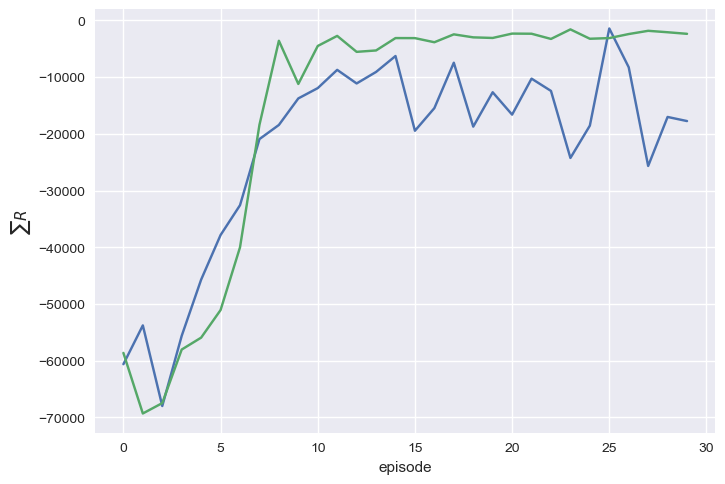

In [14]:
# train both setups once
print("Run with planning from experience")
exp_planning_history, exp_planning_pi = pendulumDynaQ(alpha=0.1, gamma=0.9, epsilon=0.1, n=19, nb_episodes=30, nb_steps=10000)

print("Run with planning from model")
model_planning_history, model_planning_pi = pendulumModelDynaQ(alpha=0.1, gamma=0.9, epsilon=0.1, n=19, nb_episodes=30, nb_steps=10000)


plt.plot(exp_planning_history)
plt.plot(model_planning_history)
plt.xlabel("episode")
plt.ylabel(r"$\sum R$")
plt.show()


Use the following cell to execute the policy we got using the model:

In [15]:
experiment(model_planning_pi, nb_steps=300, render=True)

### Extra-task:
Change the model parameters (e.g. $g$, $m$, $l$) so that our model differs from the "real world" (we got from gym).
What do you observe

By changing the parameters our model differs from the "real world". Depending on the amount of difference, the learing curve looks worse than the one with the correct values. 
The experiment result is also depending on the random starting position. 
Depending on the parameter difference, the experiment can not be executed successfully any more. 

Try to change the parameters on your own.

The Following learning curve results from a parameter change using $g =20 \, \frac{\text{m}}{\text{s}^2}, m = 5 \, \text{kg and } l = 2 \, \text{m}$:

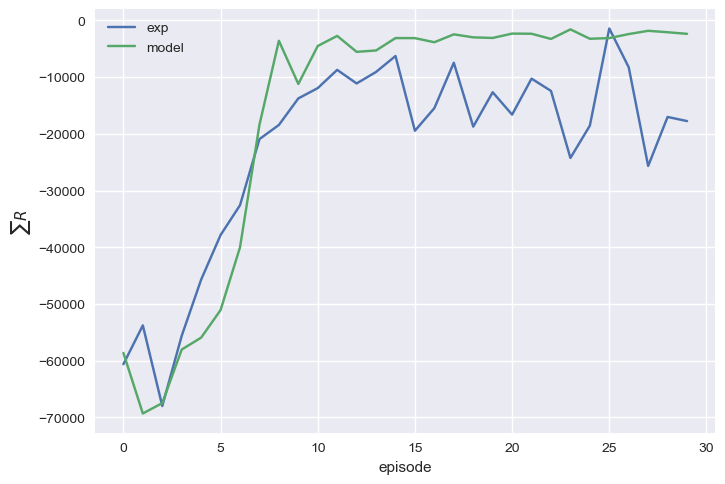

In [16]:
plt.plot(exp_planning_history, label="exp")
plt.plot(model_planning_history, label="model")
plt.xlabel("episode")
plt.ylabel(r"$\sum R$")
plt.legend(loc="upper left")
plt.show()